In [1]:
from preprocess import get_img_paths, prep_data
import numpy as np

In [2]:
fractured, nfractured = get_img_paths('train')
print(fractured) # testing data path here

['../archive/Bone_Fracture_Binary_Classification/train/fractured\\0.jpg', '../archive/Bone_Fracture_Binary_Classification/train/fractured\\0.png', '../archive/Bone_Fracture_Binary_Classification/train/fractured\\0._jumbo (1).jpeg', '../archive/Bone_Fracture_Binary_Classification/train/fractured\\0._jumbo.jpeg', '../archive/Bone_Fracture_Binary_Classification/train/fractured\\00004541.png', '../archive/Bone_Fracture_Binary_Classification/train/fractured\\000151.png', '../archive/Bone_Fracture_Binary_Classification/train/fractured\\000151594.png', '../archive/Bone_Fracture_Binary_Classification/train/fractured\\0001517989.png', '../archive/Bone_Fracture_Binary_Classification/train/fractured\\000151898.png', '../archive/Bone_Fracture_Binary_Classification/train/fractured\\000151899789.png', '../archive/Bone_Fracture_Binary_Classification/train/fractured\\0005156.png', '../archive/Bone_Fracture_Binary_Classification/train/fractured\\0010.png', '../archive/Bone_Fracture_Binary_Classificatio

In [3]:
x_1, y_1 = prep_data(fractured, 1)
x_0, y_0 = prep_data(nfractured, 0)
x_train = np.concatenate([x_0,x_1], axis=0)
x_train = np.expand_dims(x_train, axis=-1)
y_train = np.concatenate([y_0,y_1], axis=0)
x_train.shape, y_train.shape

((8538, 224, 224, 1), (8538, 1))

In [4]:
val_fractured, val_nfractured = get_img_paths('val')
x_1, y_1 = prep_data(val_fractured, 1)
x_0, y_0 = prep_data(val_nfractured, 0)
x_val = np.concatenate([x_0,x_1], axis=0)
x_val = np.expand_dims(x_val, axis=-1)
y_val = np.concatenate([y_0,y_1], axis=0)
x_val.shape, y_val.shape

((582, 224, 224, 1), (582, 1))

In [5]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [6]:
x_train_flatten = x_train.reshape((x_train.shape[0], -1))
x_val_flatten = x_val.reshape((x_val.shape[0], -1))

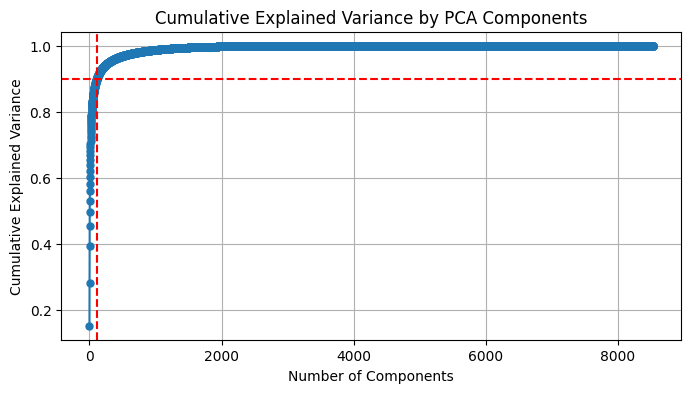

In [11]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Fit PCA on the training data
pca_full = PCA().fit(x_train.reshape(x_train.shape[0], -1))

# Determine the number of components to explain at least 90% of variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
k = np.where(cumulative_variance >= 0.90)[0][0] + 1

# Plot the cumulative variance to visualize the selection of k
plt.figure(figsize=(8, 4))
plt.plot(cumulative_variance, marker='o', linestyle='-', markersize=5)
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.90, color='r', linestyle='--')
plt.axvline(x=k, color='r', linestyle='--')
plt.grid(True)
plt.show()



c:\Users\kaleb\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6130 - loss: 187.8605 - val_accuracy: 0.7801 - val_loss: 32.1010
Epoch 2/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.8271 - loss: 23.6597 - val_accuracy: 0.8591 - val_loss: 12.1338
Epoch 3/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - accuracy: 0.8686 - loss: 11.3599 - val_accuracy: 0.9055 - val_loss: 6.1740
Epoch 4/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - accuracy: 0.9009 - loss: 6.8737 - val_accuracy: 0.9227 - val_loss: 4.3586
Epoch 5/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - accuracy: 0.9249 - loss: 3.9561 - val_accuracy: 0.9399 - val_loss: 3.0707
Epoch 6/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - accuracy: 0.9495 - loss: 2.3970 - val_accuracy: 0.9536 - val_loss: 1.9722
Epoch 7/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - accuracy: 0.9562 - loss: 1.7601 - val_accuracy: 0.9656 - val_loss: 1.2309
Epoch 8/100
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - accuracy: 0.9676 - los

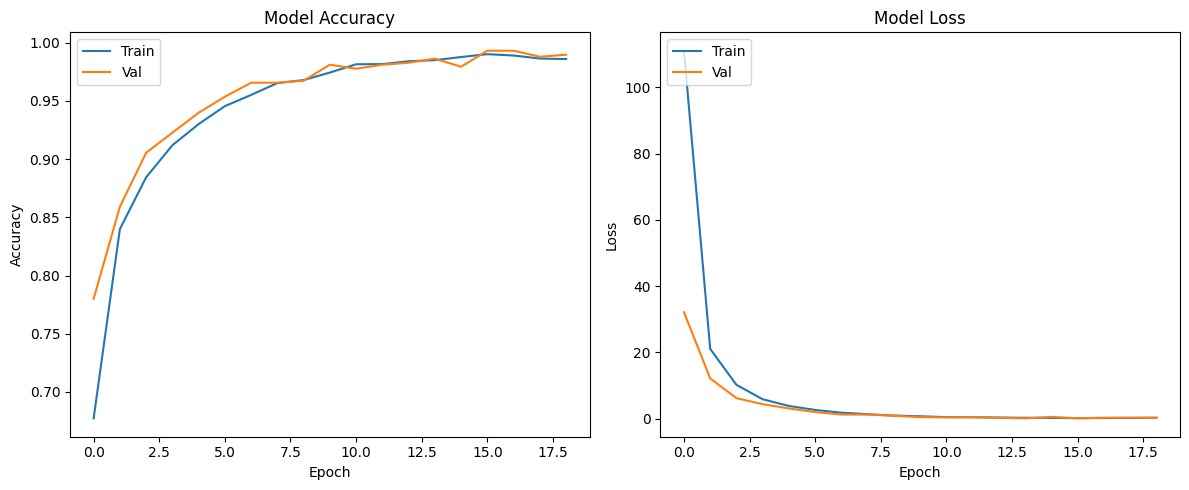

In [10]:
# Retrain classifier on PCA-reduced data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=5,            # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Apply PCA with the selected number of components
pca = PCA(n_components=k)
x_train_pca = pca.fit_transform(x_train.reshape(x_train.shape[0], -1))
x_val_pca = pca.transform(x_val.reshape(x_val.shape[0], -1))



pca_classifier = Sequential([
    Dense(10, activation='relu', input_shape=(k,)),
    Dense(1, activation='sigmoid')
])
pca_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = pca_classifier.fit(x_train_pca, y_train, epochs=100, validation_data=(x_val_pca, y_val), callbacks=[early_stopping])


# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       416
           1       0.96      0.99      0.98       166

    accuracy                           0.99       582
   macro avg       0.98      0.99      0.98       582
weighted avg       0.99      0.99      0.99       582



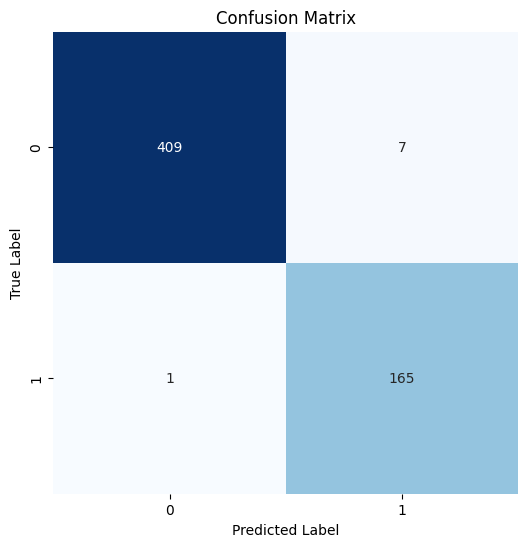

In [17]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

# Make predictions on the validation set
y_pred = pca_classifier.predict(x_val_pca)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary output

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred)
print(classification_report(y_val, y_pred))
# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
